In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import multivariate_normal
from scipy.integrate import quad
from scipy import integrate
from math import pi, sqrt, exp
import matplotlib.pyplot as plt
import random

In [ ]:
# Defining the dataset

def generate_data(n=1000, seed=0, beta1=1.05, alpha1=0.4, alpha2=0.3):
    np.random.seed(seed)
    age = np.random.normal(65, 5, n)
    sodium = age / 18 + np.random.normal(size=n)
    bloodpressure = beta1 * sodium + 2 * age + np.random.normal(size=n)
    proteinuria = alpha1 * sodium + alpha2 * bloodpressure + np.random.normal(size=n)
    return pd.DataFrame({'bloodpressure': bloodpressure, 'sodium': sodium,
                         'age': age, 'proteinuria': proteinuria})

data = generate_data(n=1000, seed=0, beta1=1.05, alpha1=0.4, alpha2=0.3)
data

,bloodpressure,sodium,age,proteinuria
0,150.997545,4.657088,73.820262,48.755372
1,137.135079,4.614740,67.000786,43.555142
2,143.467216,3.460668,69.893690,44.309945
3,156.005768,4.338295,76.204466,48.788679
4,153.170595,4.357931,74.337790,46.483495
...,...,...,...,...
995,140.222611,3.823548,67.064354,43.092313
996,132.313945,4.957524,64.008006,43.456752
997,134.735014,3.795709,65.470962,41.908215
998,119.569325,2.150429,59.261945,38.308057


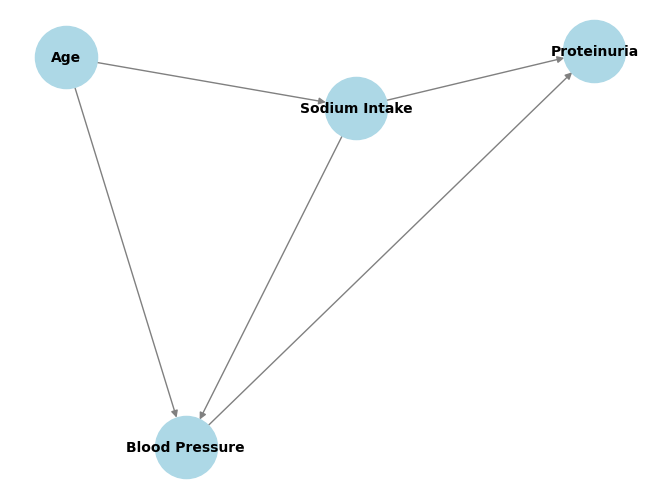

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a DAG
G = nx.DiGraph()

# Add nodes
G.add_node("Sodium Intake")
G.add_node("Blood Pressure")
G.add_node("Age")
G.add_node("Proteinuria")

# Add edges
G.add_edge("Sodium Intake", "Blood Pressure")
G.add_edge("Age", "Blood Pressure")
G.add_edge("Age", "Sodium Intake")
G.add_edge("Blood Pressure", "Proteinuria")
G.add_edge("Sodium Intake", "Proteinuria")

# Draw the graph
pos = nx.spring_layout(G)  # positions for all nodes
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=2000, font_size=10, font_weight='bold', edge_color='gray')

# Show the plot
plt.show()


In [ ]:
X = data[['sodium', 'age']]
y = data['bloodpressure']
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Training the model on the training set
model = LinearRegression()
model.fit(X_train, y_train)

# Predicting blood pressure for the testing set
y_pred_test = model.predict(X_test)

# Calculating accuracy metrics for the testing set
mse_test = mean_squared_error(y_test, y_pred_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

print('The mean square error is', mse_test)
print('The accuracy of the model is',r2_test)
coefficients = pd.DataFrame(model.coef_, X.columns, columns=['Coefficient'])
ate_sodium = coefficients.loc['sodium', 'Coefficient']
print(coefficients)

The mean square error is 0.9270908693174715
The accuracy of the model is 0.9899670126285115
        Coefficient
sodium     1.022414
age        1.993897


In [ ]:
# Estimating the ATE of sodium intake on blood pressure

X1 = pd.DataFrame.copy(X)
X1['sodium'] = 1
X0 = pd.DataFrame.copy(X)
X0['sodium'] = 0
ate_est = np.mean(model.predict(X1) - model.predict(X0))
print('ATE estimate:', ate_est)
print('The true value of the ATE of sodium intake on blood pressure is', 1.05)

ATE estimate: 1.0224143403775434
The true value of the ATE of sodium intake on blood pressure is 1.05


Now, we use the following formula to calculate the FATE of sodium intake (S) on blood pressure (B):

$$\mathrm{FATE}_l^h(S\to B):= \int_{-\infty}^{\infty}\mathbb{E}(Y(t))\left(f_h(t) - f_l(t)\right)
\,\mathrm{d} t,$$
where
$$f_l(t) =\frac{\mu_{l}(t)}{\lVert low\rVert},\qquad f_h(t) =\frac{\mu_{h}(t)}{\lVert high\rVert},\quad \lVert low\rVert = \int \mu_l(t)\,\mathrm{d} t,\;\; \lVert high\rVert = \int \mu_h(t)\,\mathrm{d} t$$
Also, $\mu_l(t)$ and $\mu_h(t)$ are defined as it is shown in the following block of the code (here $l$ and $h$ stand for $low$ and $high$, respectively).

In [ ]:
# Estimating the FATE of sodium intake on blood pressure

import scipy.integrate as spi

def expected_yt(t):
  X1 = pd.DataFrame.copy(X)
  X1['sodium'] = t
  return np.mean(model.predict(X1))

min_soidum = data['sodium'].min()
max_sodium = data['sodium'].max()
point_0 = min_soidum
point_1 = (max_sodium + min_soidum)/2
point_2 = max_sodium

# Defining mu_l(t) and mu_h(t)

def low(t):
  if point_0 <= t <= point_1:
    return -(1/(point_1 - point_0))*(t - point_1)
  else:
    return 0

def high(t):
  if point_1 <= t <= point_2:
    return (1/(point_2 - point_1))*(t - point_1)
  else:
    return 0

# Calculating ||low|| and ||high||

norm_low, _ = spi.quad(low, point_0, point_2)
norm_high, _ = spi.quad(high, point_0, point_2)

# Calculating the FATE of sodium intake on blood pressure.

def integrand_low(t):
  return expected_yt(t) * low(t)

def integrand_high(t):
  return expected_yt(t) * high(t)

expected_low, error_low = spi.quad(integrand_low, point_0, point_2)
expected_low = expected_low/norm_low

expected_high, error_high = spi.quad(integrand_high, point_0, point_2)
expected_high = expected_high/norm_high

FATE = expected_high - expected_low
print('FATE = ', FATE)
print('True value = ', (2*(point_2 - point_0)/3)*1.05)
print('To see why the true value is this, see the paper.')

FATE =  4.186487053731156
True value =  4.299442244515509
To see why the true value is this, see the paper.


$$\mathrm{NFATE}_l^h(S\to B):= \frac{\mathrm{FATE}_l^h(S\to B)}{\mathbb{E}(S-S')} = \frac{\int_{-\infty}^{\infty}\mathbb{E}(Y(t))\left(f_h(t) - f_l(t)\right)
	\,\mathrm{d} t}{\int_{-\infty}^{\infty}\int_{-\infty}^{\infty} (t-t')f_h(t)f_l(t')\, \mathrm{d}t'  \mathrm{d} t},$$
  where in $\mathbb{E}(S-S')$, $S$ and $S'$ come from the distributions based on $f_h$ and $f_l$, respectively.

In [ ]:
# Calculating E(T - T') as described above.

from scipy.integrate import dblquad

def integrand(x, y):
    return (y-x)*(low(x)/norm_low)*(high(y)/norm_high)

x_lower = 0
x_upper = 10
y_lower = lambda x: 0
y_upper = lambda x: 10

denominator, _ = dblquad(integrand, x_lower, x_upper, y_lower, y_upper)
print("NFATE = ", FATE/denominator)
print("True value = ", 1.05)

NFATE =  1.022414487238101
True value =  1.05
